#Data prprocessing

In [ ]:
url = 'https://drive.google.com/file/d/1WU9hZ-zLVOjrcwaE6WnFX_U-QElUjSKm/view?usp=sharing'
url = 'https://drive.google.com/uc?id=' + url.split('/')[-2]

In [ ]:
import json
import requests
import pandas as pd

In [ ]:
import matplotlib.pyplot as plt

from collections import Counter
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Permute, dot, add, concatenate
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Activation,RepeatVector
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import History
from tensorflow.keras.losses import CategoricalCrossentropy

In [ ]:
response = requests.get(url)

data_train = response.json()

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
lookup = 'abcdefghijklmnopqrstuvwxyz1234567890?,.'
# check for valid characters
def in_white_list(_word):
    valid_word = False
    for char in _word:
        if char in lookup:
            valid_word = True
            break

    if valid_word is False:
        return False

    return True

In [ ]:
def get_CoQA_data(qa_data,max_data_count,max_context_seq_length):
    data = list()
    for instance in qa_data['data']:
        context = instance["story"]
        context_wid_list = [w.lower() for w in nltk.word_tokenize(context) if in_white_list(w)]
        new_context = ' '.join(context_wid_list)
        if len(context_wid_list) > max_context_seq_length:
            continue

        ques = instance['questions']
        question = list()
        new_question = list()
        question_wid_list = list()

        for ques_instance in ques:
            q_id = ques_instance['turn_id']
            question.append(ques_instance['input_text'].lower())
            question_wid_list.append([w.lower() for w in nltk.word_tokenize(question[q_id-1]) if in_white_list(w)])
            new_question.append(' '.join(question_wid_list[q_id-1]))

        ans = instance['answers']
        for ans_instance in ans:
            answer = ans_instance['input_text'].lower()
            a_id = ans_instance['turn_id']
            if a_id == 1:
                question_his = ""
                answer_his = ""
            if "bad_turn" not in ans_instance:
                answer_wid_list = [w.lower() for w in nltk.word_tokenize(answer) if in_white_list(w)]
                new_answer = ' '.join(answer_wid_list)
                if len(data) < max_data_count:
                    if new_answer != '' and len(new_question[a_id-1]) > 1:
                        data.append((new_context, question_his, answer_his, new_question[a_id-1], new_answer))
                        question_his = new_question[a_id-1]
                        answer_his = new_answer

        if len(data) >= max_data_count:
            break

    return data

In [ ]:
max_data_count = 30000
max_context_seq_length = 300
data = get_CoQA_data(data_train,max_data_count,max_context_seq_length)
print("Total Q&A data size",len(data))

Total Q&A data size 30000


In [ ]:
input_data_samples = []
output_data_samples = []

input_paragraph_max_seq_length = 0
input_question_max_seq_length = 0
target_max_seq_length = 0

input_paragraph_counter = Counter()
input_question_counter = Counter()
target_counter = Counter()

for sample in data:
    paragraph, ques_his, ans_his, question, answer = sample

    paragraph_word_list = [w.lower() for w in nltk.word_tokenize(paragraph) if in_white_list(w)]
    ques_his_word_list = [w.lower() for w in nltk.word_tokenize(ques_his) if in_white_list(w)]
    ans_his_word_list = [w.lower() for w in nltk.word_tokenize(ans_his) if in_white_list(w)]
    question_word_list = [w.lower() for w in nltk.word_tokenize(question) if in_white_list(w)]
    answer_word_list = [w.lower() for w in nltk.word_tokenize(answer) if in_white_list(w)]

    output_data = ['START'] + answer_word_list + ['END']
    question_his = ['QUESTION'] + ques_his_word_list
    answer_his = ['START'] + ans_his_word_list + ['END']

    input_data_samples.append([paragraph_word_list, question_his, answer_his, question_word_list])
    output_data_samples.append(output_data)

    for w in paragraph_word_list:
        input_paragraph_counter[w] += 1
    for w in question_word_list:
        input_question_counter[w] += 1
    for w in output_data:
        target_counter[w] += 1

    input_paragraph_max_seq_length = max(input_paragraph_max_seq_length, len(paragraph_word_list))
    input_question_max_seq_length = max(input_question_max_seq_length, len(question_word_list))
    target_max_seq_length = max(target_max_seq_length, len(output_data))

In [ ]:
max_input_vocab_size = 50000
max_target_vocab_size = 50000

input_paragraph_word2idx = dict()
input_question_word2idx = dict()
question_his_word2idx = dict()
answer_his_word2idx = dict()
target_word2idx = dict()

# Mapping from word to index
for idx, word in enumerate(input_paragraph_counter.most_common(max_input_vocab_size)):
    input_paragraph_word2idx[word[0]] = idx + 2
for idx, word in enumerate(input_question_counter.most_common(max_input_vocab_size)):
    input_question_word2idx[word[0]] = idx + 2
    question_his_word2idx[word[0]] = idx + 3
for idx, word in enumerate(target_counter.most_common(max_target_vocab_size)):
    target_word2idx[word[0]] = idx + 1
    answer_his_word2idx[word[0]] = idx + 2

target_word2idx['UNK'] = 0
answer_his_word2idx['PAD'] = 0
answer_his_word2idx['UNK'] = 1

question_his_word2idx['PAD'] = 0
question_his_word2idx['UNK'] = 1
question_his_word2idx['QUESTION'] = 2

input_paragraph_word2idx['PAD'] = 0
input_paragraph_word2idx['UNK'] = 1
input_question_word2idx['PAD'] = 0
input_question_word2idx['UNK'] = 1

# Mapping from index to word
input_paragraph_idx2word = dict([(idx, word) for word, idx in input_paragraph_word2idx.items()])
question_his_idx2word = dict([(idx, word) for word, idx in question_his_word2idx.items()])
answer_his_idx2word = dict([(idx, word) for word, idx in answer_his_word2idx.items()])
input_question_idx2word = dict([(idx, word) for word, idx in input_question_word2idx.items()])
target_idx2word = dict([(idx, word) for word, idx in target_word2idx.items()])

num_input_paragraph_tokens = len(input_paragraph_idx2word)
num_input_question_tokens = len(input_question_idx2word)
num_target_tokens = len(target_idx2word)

In [ ]:
input_encoded_data_samples = []
target_encoded_data_samples = []

for input_data, output_data in zip(input_data_samples, output_data_samples):
    input_paragraph_encoded_data = []
    question_his_encoded_data = []
    answer_his_encoded_data = []
    input_question_encoded_data = []
    target_encoded_data = []
    input_paragraph_data, question_his_data, answer_his_data, input_question_data = input_data
    for word in input_paragraph_data:
        if word in input_paragraph_word2idx:
            input_paragraph_encoded_data.append(input_paragraph_word2idx[word])
        else:
            input_paragraph_encoded_data.append(1)

    for word in question_his_data:
        if word in question_his_word2idx:
            question_his_encoded_data.append(question_his_word2idx[word])
        else:
            question_his_encoded_data.append(1)

    for word in answer_his_data:
        if word in answer_his_word2idx:
            answer_his_encoded_data.append(answer_his_word2idx[word])
        else:
            answer_his_encoded_data.append(0)

    for word in input_question_data:
        if word in input_question_word2idx:
            input_question_encoded_data.append(input_question_word2idx[word])
        else:
            input_question_encoded_data.append(1)

    for word in output_data:
        if word in target_word2idx:
            target_encoded_data.append(target_word2idx[word])
        else:
            target_encoded_data.append(0)

    input_encoded_data_samples.append([input_paragraph_encoded_data, question_his_encoded_data, answer_his_encoded_data, input_question_encoded_data])
    target_encoded_data_samples.append(target_encoded_data)

In [ ]:
batch_size = 128
epochs = 10
test_size = 0.2
random_state = 42
# get train and test samples
x_train, x_test, y_train, y_test = train_test_split(input_encoded_data_samples, target_encoded_data_samples, test_size=test_size, random_state=random_state)

In [ ]:
def generate_batch(input_paragraph_max_seq_length,input_question_max_seq_length,target_max_seq_length,num_target_tokens, input_data, output_data, batch_size):
    num_batches = len(input_data) // batch_size
    while True:
        for batchIdx in range(0, num_batches):
            start = batchIdx * batch_size
            end = (batchIdx + 1) * batch_size
            encoder_input_paragraph_data_batch = []
            encoder_question_his_data_batch = []
            encoder_answer_his_data_batch = []
            encoder_input_question_data_batch = []

            for input_paragraph_data, question_his_data, answer_his_data, input_question_data in input_data[start:end]:
                encoder_input_paragraph_data_batch.append(input_paragraph_data)
                encoder_question_his_data_batch.append(question_his_data)
                encoder_answer_his_data_batch.append(answer_his_data)
                encoder_input_question_data_batch.append(input_question_data)

            encoder_input_paragraph_data_batch = pad_sequences(encoder_input_paragraph_data_batch,
                                                               input_paragraph_max_seq_length)
            encoder_question_his_data_batch = pad_sequences(encoder_question_his_data_batch,
                                                               input_question_max_seq_length+1)
            encoder_answer_his_data_batch = pad_sequences(encoder_answer_his_data_batch,
                                                               target_max_seq_length)
            encoder_input_question_data_batch = pad_sequences(encoder_input_question_data_batch,
                                                              input_question_max_seq_length)

            decoder_target_data_batch = np.zeros(shape=(batch_size, target_max_seq_length, num_target_tokens))
            decoder_input_data_batch = np.zeros(shape=(batch_size, target_max_seq_length, num_target_tokens))
            for lineIdx, target_wid_list in enumerate(output_data[start:end]):
                for idx, wid in enumerate(target_wid_list):
                    if wid == 0:  # UNKNOWN
                        continue
                    decoder_input_data_batch[lineIdx, idx, wid] = 1
                    if idx > 0:
                        decoder_target_data_batch[lineIdx, idx - 1, wid] = 1
            yield [encoder_input_paragraph_data_batch,  encoder_question_his_data_batch, encoder_answer_his_data_batch,
                   encoder_input_question_data_batch, decoder_input_data_batch], decoder_target_data_batch

train_gen = generate_batch(input_paragraph_max_seq_length,input_question_max_seq_length,target_max_seq_length,num_target_tokens, x_train, y_train, batch_size)
test_gen = generate_batch(input_paragraph_max_seq_length,input_question_max_seq_length,target_max_seq_length,num_target_tokens, x_test, y_test, batch_size)

train_num_batches = len(x_train) // batch_size
test_num_batches = len(x_test) // batch_size

#Create Model

In [ ]:
def create_model(num_encoder_paragraph_tokens,max_encoder_paragraph_seq_length,
                 num_encoder_question_tokens,max_encoder_question_seq_length, max_encoder_answer_his_seq_length, num_decoder_tokens):

    hidden_units = 256
    embed_hidden_units = 100

    context_inputs = Input(shape=(None,), name='context_inputs')
    encoded_context = Embedding(input_dim=num_encoder_paragraph_tokens, output_dim=embed_hidden_units,
                                    input_length=max_encoder_paragraph_seq_length,
                                    name='context_embedding')(context_inputs)

    question_his = Input(shape=(None,), name='question_his')
    encoded_question_his = Embedding(input_dim=num_encoder_question_tokens, output_dim=embed_hidden_units,
                                     input_length=max_encoder_question_seq_length+1,
                                     name='question_his_embedding')(question_his)

    answer_his = Input(shape=(None,), name='answer_his')
    encoded_answer_his = Embedding(input_dim=num_encoder_question_tokens, output_dim=embed_hidden_units,
                                     input_length=max_encoder_answer_his_seq_length,
                                     name='answer_his_embedding')(answer_his)

    question_inputs = Input(shape=(None,), name='question_inputs')
    encoded_question = Embedding(input_dim=num_encoder_question_tokens, output_dim=embed_hidden_units,
                                     input_length=max_encoder_question_seq_length,
                                     name='question_embedding')(question_inputs)

    encoded_question_his = LSTM(units=embed_hidden_units, name='question_his_lstm')(encoded_question_his)
    encoded_question_his = RepeatVector(max_encoder_paragraph_seq_length)(encoded_question_his)

    encoded_answer_his = LSTM(units=embed_hidden_units, name='answer_his_lstm')(encoded_answer_his)
    encoded_answer_his = RepeatVector(max_encoder_paragraph_seq_length)(encoded_answer_his)

    encoded_question = LSTM(units=embed_hidden_units, name='question_lstm')(encoded_question)
    encoded_question = RepeatVector(max_encoder_paragraph_seq_length)(encoded_question)

    merged = add([encoded_context, encoded_question_his, encoded_answer_his, encoded_question])

    encoder_lstm = LSTM(units=hidden_units, return_state=True, name='encoder_lstm')
    encoder_outputs, encoder_state_h, encoder_state_c = encoder_lstm(merged)
    encoder_states = [encoder_state_h, encoder_state_c]

    decoder_inputs = Input(shape=(None, num_decoder_tokens), name='decoder_inputs')
    decoder_lstm = LSTM(units=hidden_units, return_state=True, return_sequences=True, name='decoder_lstm')
    decoder_outputs, decoder_state_h, decoder_state_c = decoder_lstm(decoder_inputs,
                                                                         initial_state=encoder_states)
    decoder_dense = Dense(units=num_decoder_tokens, activation='softmax', name='decoder_dense')
    decoder_outputs = decoder_dense(decoder_outputs)

    model = Model([context_inputs, question_his, answer_his, question_inputs, decoder_inputs], decoder_outputs)

    optimizer = optimizers.Adam(lr = 0.001)
    loss_func = CategoricalCrossentropy()
    model.compile(optimizer = optimizer, loss = loss_func, metrics = ['accuracy'])

    encoder_model = Model([context_inputs, question_his, answer_his, question_inputs], encoder_states)

    decoder_state_inputs = [Input(shape=(hidden_units,)), Input(shape=(hidden_units,))]
    decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_state_inputs)
    decoder_states = [state_h, state_c]
    decoder_outputs = decoder_dense(decoder_outputs)
    decoder_model = Model([decoder_inputs] + decoder_state_inputs, [decoder_outputs] + decoder_states)

    return model, encoder_model, decoder_model

model, encoder_model, decoder_model = create_model(num_input_paragraph_tokens,input_paragraph_max_seq_length,
                 num_input_question_tokens,input_question_max_seq_length, target_max_seq_length, num_target_tokens)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 question_inputs (InputLaye  [(None, None)]               0         []                            
 r)                                                                                               
                                                                                                  
 question_his (InputLayer)   [(None, None)]               0         []                            
                                                                                                  
 answer_his (InputLayer)     [(None, None)]               0         []                            
                                                                                                  
 question_embedding (Embedd  (None, None, 100)            1088600   ['question_inputs[0][0]'] 

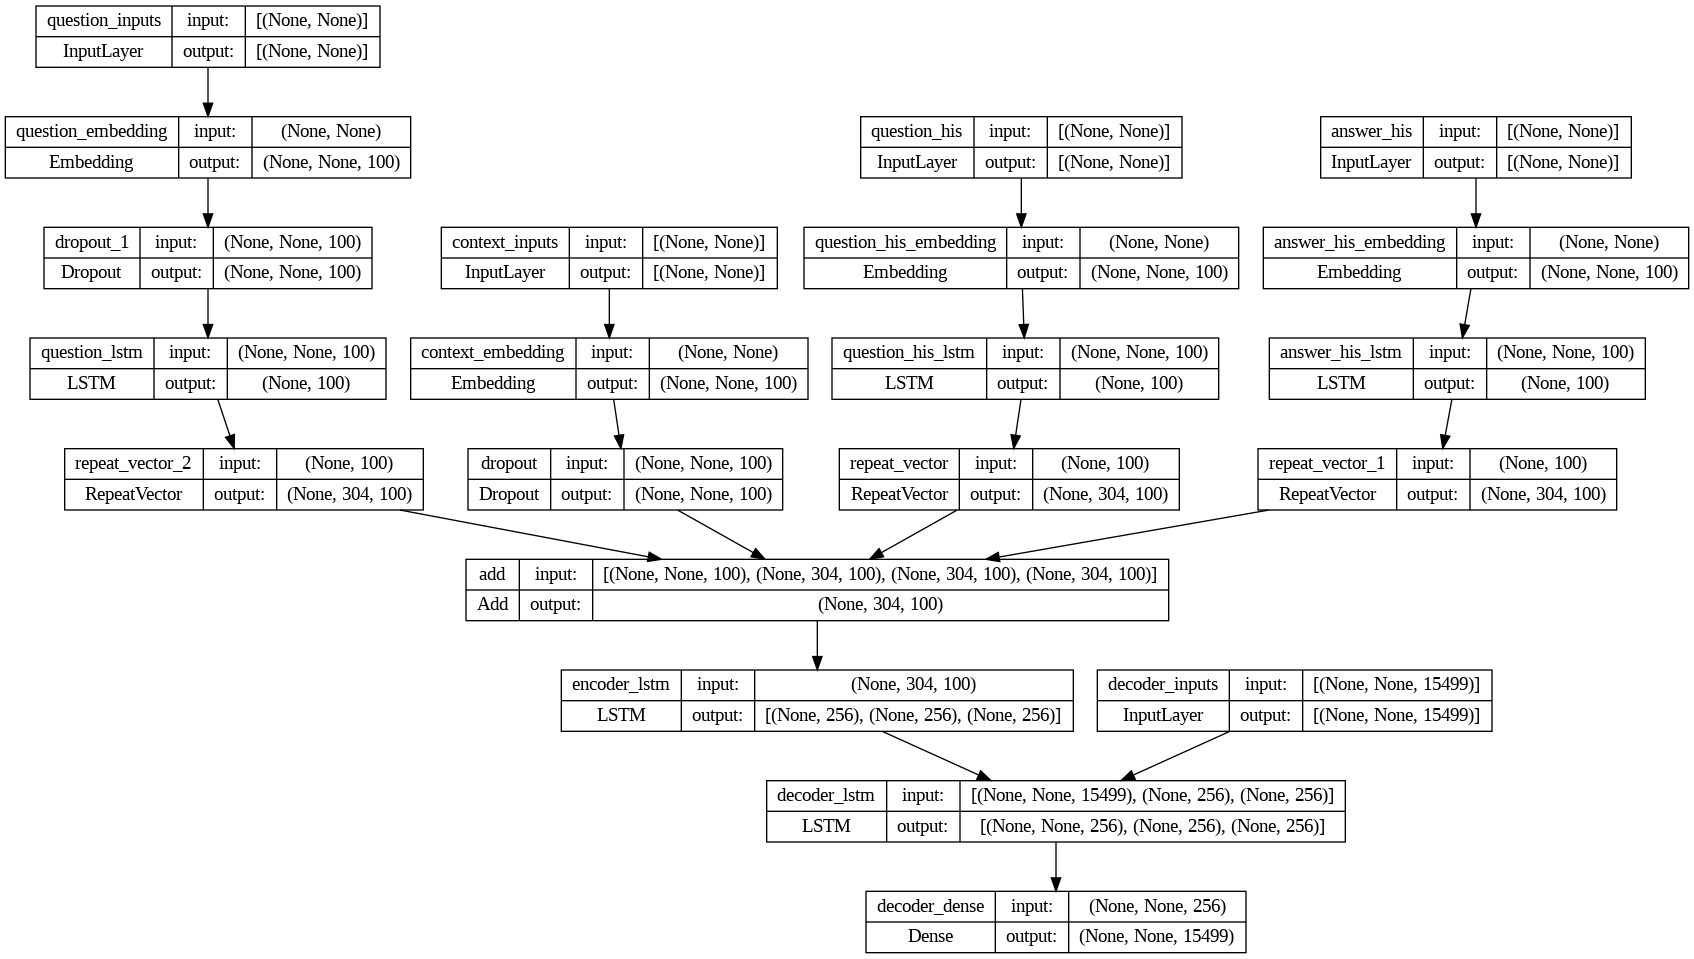

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)

#Train Model

In [ ]:
filepath = "/content/model/our_model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
reduce_alpha = ReduceLROnPlateau(monitor ='val_loss', factor = 0.2, patience = 1, min_lr = 0.001)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)
callbacks = [checkpoint, reduce_alpha]

In [ ]:
import numpy as np

In [ ]:
history = model.fit(train_gen, steps_per_epoch=train_num_batches,
                    epochs=epochs,
                    verbose=1, validation_data=test_gen, validation_steps=test_num_batches,
                    callbacks=callbacks)

Epoch 1/10
187/187 [==============================] - ETA: 0s - loss: 0.2229 - accuracy: 0.0106
Epoch 1: val_loss improved from inf to 0.21641, saving model to /content/model/our_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


187/187 [==============================] - 760s 4s/step - loss: 0.2229 - accuracy: 0.0106 - val_loss: 0.2164 - val_accuracy: 0.0083 - lr: 0.0010
Epoch 2/10
187/187 [==============================] - ETA: 0s - loss: 0.2151 - accuracy: 0.0083
Epoch 2: val_loss improved from 0.21641 to 0.21633, saving model to /content/model/our_model.h5
187/187 [==============================] - 702s 4s/step - loss: 0.2151 - accuracy: 0.0083 - val_loss: 0.2163 - val_accuracy: 0.0083 - lr: 0.0010
Epoch 3/10
187/187 [==============================] - ETA: 0s - loss: 0.2150 - accuracy: 0.0083
Epoch 3: val_loss improved from 0.21633 to 0.21633, saving model to /content/model/our_model.h5
187/187 [==============================] - 697s 4s/step - loss: 0.2150 - accuracy: 0.0083 - val_loss: 0.2163 - val_accuracy: 0.0083 - lr: 0.0010
Epoch 4/10
187/187 [==============================] - ETA: 0s - loss: 0.2151 - accuracy: 0.0083
Epoch 4: val_loss did not improve from 0.21633
187/187 [=============================

#Testing

In [ ]:
def reply(paragraph, question_his, answer_his, question):
    input_paragraph_seq = []
    question_his_seq = []
    answer_his_seq = []
    input_question_seq = []
    input_paragraph_wid_list = []
    question_his_wid_list = []
    answer_his_wid_list = []
    input_question_wid_list = []
    input_paragraph_text = paragraph.lower()
    question_his_text = question_his.lower()
    answer_his_text = answer_his.lower()
    input_question_text = question.lower()
    for word in nltk.word_tokenize(input_paragraph_text):
        if not in_white_list(word):
            continue
        idx = 1  # default [UNK]
        if word in input_paragraph_word2idx:
            idx = input_paragraph_word2idx[word]
        input_paragraph_wid_list.append(idx)
    for word in nltk.word_tokenize(input_question_text):
        if not in_white_list(word):
            continue
            idx = 1  # default [UNK]
        if word in input_question_word2idx:
            idx = input_question_word2idx[word]
        input_question_wid_list.append(idx)
    for word in nltk.word_tokenize(question_his_text):
        if not in_white_list(word):
            continue
            idx = 1  # default [UNK]
        if word in question_his_word2idx:
            idx = question_his_word2idx[word]
        question_his_wid_list.append(idx)
    for word in nltk.word_tokenize(answer_his_text):
        if not in_white_list(word):
            continue
            idx = 1  # default [UNK]
        if word in answer_his_word2idx:
            idx = answer_his_word2idx[word]
        answer_his_wid_list.append(idx)

    input_paragraph_seq.append(input_paragraph_wid_list)
    input_question_seq.append(input_question_wid_list)
    question_his_seq.append(question_his_wid_list)
    answer_his_seq.append(answer_his_wid_list)

    input_paragraph_seq = pad_sequences(input_paragraph_seq, input_paragraph_max_seq_length)
    input_question_seq = pad_sequences(input_question_seq, input_question_max_seq_length)
    question_his_seq = pad_sequences(question_his_seq, input_question_max_seq_length+1)
    answer_his_seq = pad_sequences(answer_his_seq, target_max_seq_length)
    states_value = encoder_model.predict([input_paragraph_seq, question_his_seq, answer_his_seq, input_question_seq])

    target_seq = np.zeros((1, 1, num_target_tokens))
    target_seq[0, 0, target_word2idx['START']] = 1
    target_text = ''
    target_text_len = 0
    terminated = False
    while not terminated:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value, verbose=None)

        sample_token_idx = np.argmax(output_tokens[0, -1, :])
        sample_word = target_idx2word[sample_token_idx]
        target_text_len += 1

        if sample_word != 'START' and sample_word != 'END':
            target_text += ' ' + sample_word

        if sample_word == 'START' or target_text_len >= target_max_seq_length:
            terminated = True

        target_seq = np.zeros((1, 1, num_target_tokens))
        target_seq[0, 0, sample_token_idx] = 1

        states_value = [h, c]
    return target_text.strip()

In [ ]:
for i in range(20):
    index = i * 10
    paragraph, question_his, answer_his, question, actual_answer = data[index]
    predicted_answer = reply(paragraph, question_his, answer_his, question)
    print('context: ', paragraph)
    print("conversatoin history: ", question_his, answer_his)
    print('question: ', question)
    print({'guessed_answer': predicted_answer, 'actual_answer': actual_answer})
    print("\n")

1/1 [==============================] - 1s 1s/step
context:  the vatican apostolic library , more commonly called the vatican library or simply the vat , is the library of the holy see , located in vatican city . formally established in 1475 , although it is much older , it is one of the oldest libraries in the world and contains one of the most significant collections of historical texts . it has 75,000 codices from throughout history , as well as 1.1 million printed books , which include some 8,500 incunabula . the vatican library is a research library for history , law , philosophy , science and theology . the vatican library is open to anyone who can document their qualifications and research needs . photocopies for private study of pages from books published between 1801 and 1990 can be requested in person or by mail . in march 2014 , the vatican library began an initial four-year project of digitising its collection of manuscripts , to be made available online . the vatican secret

#Evaluate

In [ ]:
!rm squad.py
!wget https://raw.githubusercontent.com/allenai/allennlp-models/main/allennlp_models/rc/tools/squad.py
import squad

rm: cannot remove 'squad.py': No such file or directory
--2024-02-01 08:45:52--  https://raw.githubusercontent.com/allenai/allennlp-models/main/allennlp_models/rc/tools/squad.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2687 (2.6K) [text/plain]
Saving to: ‘squad.py’

squad.py            100%[===================>]   2.62K  --.-KB/s    in 0s      

2024-02-01 08:45:52 (40.9 MB/s) - ‘squad.py’ saved [2687/2687]



In [ ]:
em_score = []
f1_score = []

for i in data[-400:-1]:
    paragraph, question_his, answer_his, question, actual_answer = i
    predicted_answer = reply(paragraph, question_his, answer_his, question)
    em_score.append(squad.compute_exact(predicted_answer, actual_answer))
    f1_score.append(squad.compute_f1(predicted_answer, actual_answer))

em_score = np.mean(em_score)
f1_score = np.mean(f1_score)

1/1 [==============================] - 0s 26ms/step


KeyboardInterrupt: 

In [ ]:
em_score

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [ ]:
f1_score